# Synthetic Data for Testing

In [1]:
from watttime.evaluator.sessions import SessionsGenerator

In [ ]:
os.environ[""]

## Example: At home EV charging

- Covers a 5.5 - 8.5 hour variable length window
- The vehicle has a BMW and has an average power draw of 42.5
- Battery is usually typically 50% charged at plug in time.
- Charging occurs during the workday

In [ ]:
ev_kwargs = {
    "max_power_output_rates": [42.5],
    "max_percent_capacity": 0.95,  # highest level of charge achieved by battery
    "power_output_efficiency": 0.75,  # power loss. 1 = no power loss.
    "minimum_battery_starting_capacity": 0.2,  # minimum starting percent charged
    "minimum_usage_window_start_time": "08:00:00",  # session can start as early as 9am
    "maximum_usage_window_start_time": "22:00:00",  # session can start as late as 9pm
}

In [3]:
s_ev = SessionsGenerator(**ev_kwargs)

Now we can generate synthetic data for users and devices with the attributes set above. The synthetic data creates one example per day.

In [4]:
# the class has a helper function to generate a random list of unique dates
distinct_date_list = s_ev.assign_random_dates(years=[2025])

You can generate data from a single user.

In [ ]:
#s_ev.synthetic_user_data(distinct_date_list=[distinct_date_list[0]]).head().T

Or for multiple users.

In [ ]:
#s_ev.generate_synthetic_dataset(distinct_date_list=[distinct_date_list[0]], number_of_users=10).sample(5)

In [5]:
df_ev = s_ev.generate_synthetic_dataset(distinct_date_list=distinct_date_list, number_of_users=10)

100%|██████████| 10/10 [00:00<00:00, 288.63it/s]


In [7]:
df_ev.rename({'usage_time_required_in_minutes':'time_needed'}, axis=1, inplace=True)
df_ev = df_ev.loc[df_ev.time_needed > 0]
df_ev = df_ev.loc[df_ev.early_session_stop == False]

<Axes: ylabel='Frequency'>

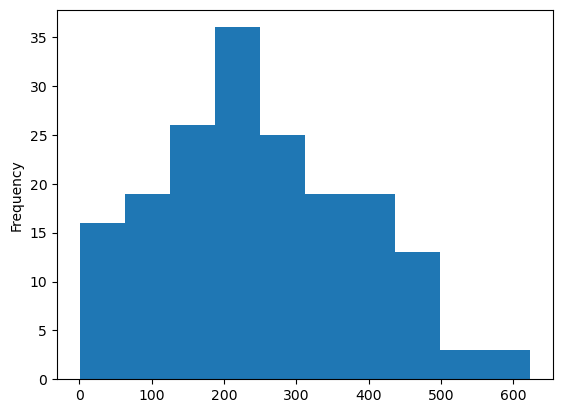

In [10]:
(df_ev.window_length_in_minutes - df_ev.time_needed).plot(kind='hist')

<Axes: ylabel='Frequency'>

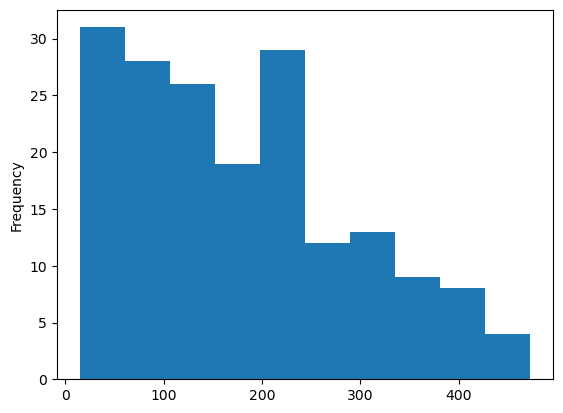

In [8]:
df_ev.time_needed.plot(kind='hist')

<Axes: ylabel='Frequency'>

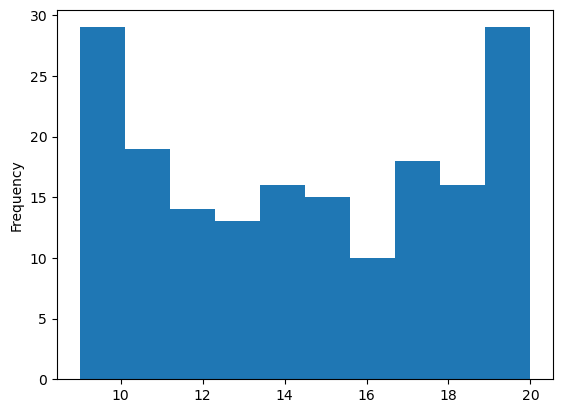

In [ ]:
df_ev.usage_window_start.dt.hour.plot(kind='hist') # hour of the day

## Example: AI Model Training
- Model training can occur at any time of day
- There are 3 server models that consume 240, 310, and 400 watt-hour on average
- Early stopping is not an option

In [ ]:
ai_kwargs = {
    "max_percent_capacity":1.0, # job must run to completion
    "max_power_output_rates": [24,31,64], # assuming a bare metal usecase, k8s or vm rescale to vCPU
    "minimum_usage_window_start_time": "00:00:00",  # earliest session can start
    "maximum_usage_window_start_time": "23:59:00",  # latest session can start
}

In [ ]:
s_ai = SessionsGenerator(**ai_kwargs)

In [ ]:
df_ai = s_ai.generate_synthetic_dataset(distinct_date_list=distinct_date_list, number_of_users=10)

# Optimization

In [12]:
import os
from watttime.evaluator.evaluator import OptChargeEvaluator
from watttime.evaluator.evaluator import ImpactEvaluator
import pandas as pd

In [329]:
username = 'jbadolato'
# os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")
region = "CAISO_NORTH"

In [330]:
oce = OptChargeEvaluator(username=username,password=password)

In [24]:
df_ev_sample = df_ev.sample(5)

In [43]:
df_ev_sample.tail()

,index,distinct_dates,user_type,usage_window_start,usage_window_end,initial_charge,time_needed,expected_baseline_charge_complete_timestamp,window_length_in_minutes,final_charge_time,total_capacity,usage_power_kw,total_intervals_plugged_in,MWh_fraction,early_session_stop
197,8,2025-02-04,r34.34_tc42_avglc20263_sdlc7287,2025-02-04 13:25:00,2025-02-04 20:20:00,0.646464,22.274639,2025-02-04 13:47:16.478335626,415.0,2025-02-04 13:47:16.478335626,42,34.3400,83.0,0.002862,False
206,17,2025-03-07,r34.34_tc42_avglc20263_sdlc7287,2025-03-07 19:20:00,2025-03-08 03:15:00,0.222331,53.399147,2025-03-07 20:13:23.948791506,475.0,2025-03-07 20:13:23.948791506,42,34.3400,95.0,0.002862,False
198,9,2025-02-09,r34.34_tc42_avglc20263_sdlc7287,2025-02-09 11:40:00,2025-02-09 19:10:00,0.715327,17.221231,2025-02-09 11:57:13.273880550,450.0,2025-02-09 11:57:13.273880550,42,34.3400,90.0,0.002862,False
114,9,2025-02-09,r3.7296_tc22_avglc21343_sdlc7953,2025-02-09 10:50:00,2025-02-09 16:50:00,0.573994,133.078202,2025-02-09 13:03:04.692090966,360.0,2025-02-09 13:03:04.692090966,22,3.7296,72.0,0.000311,False
82,19,2025-03-16,r21.76_tc117_avglc26397_sdlc7520,2025-03-16 12:45:00,2025-03-16 21:55:00,0.307424,207.301617,2025-03-16 16:12:18.097028220,550.0,2025-03-16 16:12:18.097028220,117,21.7600,110.0,0.001813,False


In [331]:
%%capture
input_dict = df_ev_sample[['usage_window_start',
                    'usage_window_end',
                    'time_needed',
                    'usage_power_kw'
                    ]].T.to_dict()

# 4 seconds per row, mostly API call
results = {}
for key,value in input_dict.items():
    value.update({'region':region,'tz_convert':True, "verbose":False})
    df = oce.get_schedule_and_cost_api(**value)
    r = ImpactEvaluator(username,password,df).get_all_emissions_values(region=region)
    results.update({key:r})

HTTPError: 403 Client Error: Forbidden for url: https://api.watttime.org/login

In [27]:
df_ev_results = df_ev_sample.merge(pd.DataFrame.from_dict(results,orient="index"), left_index=True, right_index=True)

In [28]:
df_ev_results["change_in_emissions"] = df_ev_results["actual"] - df_ev_results["baseline"]

<Axes: ylabel='Frequency'>

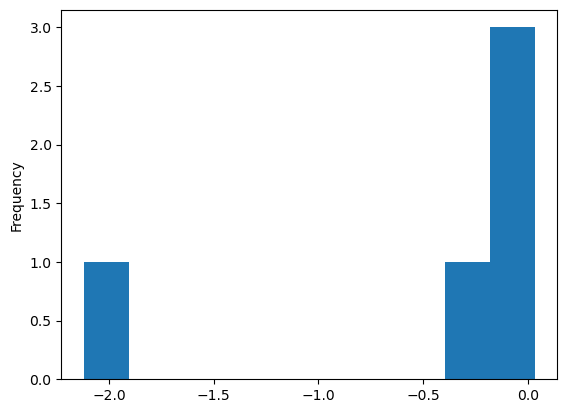

In [29]:
df_ev_results.change_in_emissions.plot(kind='hist')

In [72]:
df_ev_results

,index,distinct_dates,user_type,usage_window_start,usage_window_end,initial_charge,time_needed,expected_baseline_charge_complete_timestamp,window_length_in_minutes,final_charge_time,total_capacity,usage_power_kw,total_intervals_plugged_in,MWh_fraction,early_session_stop,baseline,forecast,actual,change_in_emissions
197,8,2025-02-04,r34.34_tc42_avglc20263_sdlc7287,2025-02-04 13:25:00,2025-02-04 20:20:00,0.646464,22.274639,2025-02-04 13:47:16.478335626,415.0,2025-02-04 13:47:16.478335626,42,34.3400,83.0,0.002862,False,12.713134,10.923134,12.486523,-2.266117e-01
206,17,2025-03-07,r34.34_tc42_avglc20263_sdlc7287,2025-03-07 19:20:00,2025-03-08 03:15:00,0.222331,53.399147,2025-03-07 20:13:23.948791506,475.0,2025-03-07 20:13:23.948791506,42,34.3400,95.0,0.002862,False,30.663299,28.744524,28.544096,-2.119203e+00
198,9,2025-02-09,r34.34_tc42_avglc20263_sdlc7287,2025-02-09 11:40:00,2025-02-09 19:10:00,0.715327,17.221231,2025-02-09 11:57:13.273880550,450.0,2025-02-09 11:57:13.273880550,42,34.3400,90.0,0.002862,False,0.972591,1.169335,0.972591,0.000000e+00
114,9,2025-02-09,r3.7296_tc22_avglc21343_sdlc7953,2025-02-09 10:50:00,2025-02-09 16:50:00,0.573994,133.078202,2025-02-09 13:03:04.692090966,360.0,2025-02-09 13:03:04.692090966,22,3.7296,72.0,0.000311,False,0.846820,1.184431,0.879627,3.280723e-02
82,19,2025-03-16,r21.76_tc117_avglc26397_sdlc7520,2025-03-16 12:45:00,2025-03-16 21:55:00,0.307424,207.301617,2025-03-16 16:12:18.097028220,550.0,2025-03-16 16:12:18.097028220,117,21.7600,110.0,0.001813,False,9.810864,14.296282,9.810864,1.776357e-15


# Requery

In [221]:
import watttime.evaluator.evaluator as wee
import importlib

In [321]:
importlib.reload(wee)
roce = wee.RecalculationOptChargeEvaluator(username,password)

In [322]:
input_dict = df_ev_sample[['usage_window_start',
                    'usage_window_end',
                    'time_needed',
                    'usage_power_kw'
                    ]].T.to_dict()

In [ ]:
'''
# Inspect the schedules
for key,value in input_dict.items():
        value.update({
            'region':region,
            'tz_convert':True, 
            "optimization_method": "simple", 
            "verbose":False,
            "interval":45,
            "charge_per_interval":None
            }
            )
        recalculator_2 = roce.fit_recalculator(**value)'

r = ImpactEvaluator(username,password,recalculator_2.get_combined_schedule()).get_all_emissions_values(region=region)
'''

162.30161713704624
117.30161713704624
72.30161713704624
27.301617137046236
0.30161713704623594


In [323]:
# 4 seconds per row, mostly API call
results_r = {}
for key,value in input_dict.items():
    value.update(
        {'region':region,
         'tz_convert':True, 
         "optimization_method": "simple", 
         "verbose":False,
         "interval":15,
         "charge_per_interval":None}
        )
    df = roce.fit_recalculator(**value)
    r = ImpactEvaluator(username,password,df).get_all_emissions_values(region=region)
    results_r.update({key:r})

In [324]:
df_ev_results_requery = df_ev_sample.merge(pd.DataFrame.from_dict(results_r,orient="index"), left_index=True, right_index=True)

In [328]:
df_ev_results_requery

,index,distinct_dates,user_type,usage_window_start,usage_window_end,initial_charge,time_needed,expected_baseline_charge_complete_timestamp,window_length_in_minutes,final_charge_time,total_capacity,usage_power_kw,total_intervals_plugged_in,MWh_fraction,early_session_stop,baseline,forecast,actual,change_in_emissions
197,8,2025-02-04,r34.34_tc42_avglc20263_sdlc7287,2025-02-04 13:25:00,2025-02-04 20:20:00,0.646464,22.274639,2025-02-04 13:47:16.478335626,415.0,2025-02-04 13:47:16.478335626,42,34.3400,83.0,0.002862,False,12.713134,12.198486,12.549504,-1.636309e-01
206,17,2025-03-07,r34.34_tc42_avglc20263_sdlc7287,2025-03-07 19:20:00,2025-03-08 03:15:00,0.222331,53.399147,2025-03-07 20:13:23.948791506,475.0,2025-03-07 20:13:23.948791506,42,34.3400,95.0,0.002862,False,30.663299,28.709920,28.661424,-2.001875e+00
198,9,2025-02-09,r34.34_tc42_avglc20263_sdlc7287,2025-02-09 11:40:00,2025-02-09 19:10:00,0.715327,17.221231,2025-02-09 11:57:13.273880550,450.0,2025-02-09 11:57:13.273880550,42,34.3400,90.0,0.002862,False,0.972591,1.169335,0.972591,0.000000e+00
114,9,2025-02-09,r3.7296_tc22_avglc21343_sdlc7953,2025-02-09 10:50:00,2025-02-09 16:50:00,0.573994,133.078202,2025-02-09 13:03:04.692090966,360.0,2025-02-09 13:03:04.692090966,22,3.7296,72.0,0.000311,False,0.846820,1.032885,0.847011,1.913410e-04
82,19,2025-03-16,r21.76_tc117_avglc26397_sdlc7520,2025-03-16 12:45:00,2025-03-16 21:55:00,0.307424,207.301617,2025-03-16 16:12:18.097028220,550.0,2025-03-16 16:12:18.097028220,117,21.7600,110.0,0.001813,False,9.810864,9.315883,9.810864,1.776357e-15


In [327]:
df_ev_results_requery["change_in_emissions"] = df_ev_results_requery["actual"] - df_ev_results_requery["baseline"]

In [326]:
df_ev_results

,index,distinct_dates,user_type,usage_window_start,usage_window_end,initial_charge,time_needed,expected_baseline_charge_complete_timestamp,window_length_in_minutes,final_charge_time,total_capacity,usage_power_kw,total_intervals_plugged_in,MWh_fraction,early_session_stop,baseline,forecast,actual,change_in_emissions
197,8,2025-02-04,r34.34_tc42_avglc20263_sdlc7287,2025-02-04 13:25:00,2025-02-04 20:20:00,0.646464,22.274639,2025-02-04 13:47:16.478335626,415.0,2025-02-04 13:47:16.478335626,42,34.3400,83.0,0.002862,False,12.713134,10.923134,12.486523,-2.266117e-01
206,17,2025-03-07,r34.34_tc42_avglc20263_sdlc7287,2025-03-07 19:20:00,2025-03-08 03:15:00,0.222331,53.399147,2025-03-07 20:13:23.948791506,475.0,2025-03-07 20:13:23.948791506,42,34.3400,95.0,0.002862,False,30.663299,28.744524,28.544096,-2.119203e+00
198,9,2025-02-09,r34.34_tc42_avglc20263_sdlc7287,2025-02-09 11:40:00,2025-02-09 19:10:00,0.715327,17.221231,2025-02-09 11:57:13.273880550,450.0,2025-02-09 11:57:13.273880550,42,34.3400,90.0,0.002862,False,0.972591,1.169335,0.972591,0.000000e+00
114,9,2025-02-09,r3.7296_tc22_avglc21343_sdlc7953,2025-02-09 10:50:00,2025-02-09 16:50:00,0.573994,133.078202,2025-02-09 13:03:04.692090966,360.0,2025-02-09 13:03:04.692090966,22,3.7296,72.0,0.000311,False,0.846820,1.184431,0.879627,3.280723e-02
82,19,2025-03-16,r21.76_tc117_avglc26397_sdlc7520,2025-03-16 12:45:00,2025-03-16 21:55:00,0.307424,207.301617,2025-03-16 16:12:18.097028220,550.0,2025-03-16 16:12:18.097028220,117,21.7600,110.0,0.001813,False,9.810864,14.296282,9.810864,1.776357e-15


## Contiguous charging example

In [ ]:
df_ai.rename({'usage_time_required_in_minutes':'time_needed'}, axis=1, inplace=True)
df_ai["charge_per_interval"] = df_ai["time_needed"].astype(int).apply(lambda x: [x])

In [ ]:
input_dict = df_ai[['usage_window_start',
                    'usage_window_end',
                    'time_needed',
                    'usage_power_kw',
                    'charge_per_interval'
                    ]].T.to_dict()

In [ ]:
impactvals = {}
for key,value in input_dict.items():
    value.update({'region':region,'tz_convert':True, "verbose":False})
    try:
        df = oce.get_schedule_and_cost_api(**value)
        r = ImpactEvaluator(username,password,df).get_all_emissions_values(region=region)
        impactvals.update({key:r})
    except:
        pass

In [ ]:
import watttime.evaluator.evaluator as wee
roce = wee.RecalculationOptChargeEvaluator(username,password)

In [68]:
input_dict = df_ev[['usage_window_start',
                    'usage_window_end',
                    'time_needed',
                    'usage_power_kw'
                    ]].T.to_dict()

In [75]:
input_dict

{82: {'usage_window_start': Timestamp('2025-03-16 12:45:00'),
  'usage_window_end': Timestamp('2025-03-16 21:55:00'),
  'time_needed': 207.30161713704624,
  'usage_power_kw': 21.76,
  'region': 'CAISO_NORTH',
  'tz_convert': True,
  'verbose': False}}

In [ ]:
# 4 seconds per row, mostly API call
results = {}
for key,value in input_dict.items():
    try:
        value.update({'tz_convert':True, 'charge_per_interval':None, 'verbose':False})
        df = roce.fit_recalculator(**value)
        r = ImpactEvaluator(username,password,df).get_all_emissions_values(region=region)
        results.update({key:r})
    except:
        pass

UTC yes
None
False
60.0
None
2025-01-11 17:30:00+00:00
None
2025-01-11 18:30:00+00:00
None
2025-01-11 19:30:00+00:00
None
2025-01-11 20:30:00+00:00
None
2025-01-11 21:30:00+00:00
None
2025-01-11 22:30:00+00:00
UTC yes
None
False
60.0
None
2025-01-12 19:15:00+00:00
None
2025-01-12 20:15:00+00:00
None
2025-01-12 21:15:00+00:00
None
2025-01-12 22:15:00+00:00
None
2025-01-12 23:15:00+00:00
None
2025-01-13 00:15:00+00:00
None
2025-01-13 01:15:00+00:00
UTC yes
None
False
60.0
None
2025-01-17 20:10:00+00:00
None
2025-01-17 21:10:00+00:00
None
2025-01-17 22:10:00+00:00
None
2025-01-17 23:10:00+00:00
None
2025-01-18 00:10:00+00:00
None
2025-01-18 01:10:00+00:00
UTC yes
None
False
60.0
None
2025-01-21 19:10:00+00:00
None
2025-01-21 20:10:00+00:00
None
2025-01-21 21:10:00+00:00
None
2025-01-21 22:10:00+00:00
None
2025-01-21 23:10:00+00:00
UTC yes
None
False
60.0
None
2025-01-27 03:10:00+00:00
None
2025-01-27 04:10:00+00:00
None
2025-01-27 05:10:00+00:00
None
2025-01-27 06:10:00+00:00
None
2025-01

/Users/jen/watttime-python-client/watttime/api.py:727: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  forecast_df.index = pd.to_datetime(forecast_df.index)


None
2025-02-03 19:25:00+00:00
None
2025-02-03 20:25:00+00:00
None
2025-02-03 21:25:00+00:00
None
2025-02-03 22:25:00+00:00
None
2025-02-03 23:25:00+00:00
None
2025-02-04 00:25:00+00:00
UTC yes
None
False
60.0
None
2025-02-09 21:50:00+00:00
None
2025-02-09 22:50:00+00:00
None
2025-02-09 23:50:00+00:00
None
2025-02-10 00:50:00+00:00
UTC yes
None
False
60.0
None
2025-02-11 19:10:00+00:00
None
2025-02-11 20:10:00+00:00
None
2025-02-11 21:10:00+00:00
None
2025-02-11 22:10:00+00:00
None
2025-02-11 23:10:00+00:00
UTC yes
None
False
60.0
None
2025-02-14 00:00:00+00:00
None
2025-02-14 01:00:00+00:00
UTC yes
None
False
60.0
None
2025-02-17 18:00:00+00:00
None
2025-02-17 19:00:00+00:00
None
2025-02-17 20:00:00+00:00
None
2025-02-17 21:00:00+00:00
None
2025-02-17 22:00:00+00:00
None
2025-02-17 23:00:00+00:00
None
2025-02-18 00:00:00+00:00
UTC yes
None
False
60.0
None
2025-03-01 00:05:00+00:00
None
2025-03-01 01:05:00+00:00
None
2025-03-01 02:05:00+00:00
None
2025-03-01 03:05:00+00:00
None
2025-03

/Users/jen/watttime-python-client/watttime/api.py:727: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  forecast_df.index = pd.to_datetime(forecast_df.index)


None
2025-01-12 19:25:00+00:00
UTC yes
None
False
60.0
None
2025-01-17 17:20:00+00:00
None
2025-01-17 18:20:00+00:00
UTC yes
None
False
60.0
None
2025-01-20 02:25:00+00:00
None
2025-01-20 03:25:00+00:00
None
2025-01-20 04:25:00+00:00
None
2025-01-20 05:25:00+00:00
UTC yes
None
False
60.0
None
2025-01-21 23:00:00+00:00
None
2025-01-22 00:00:00+00:00
UTC yes
None
False
60.0
None
2025-01-26 23:55:00+00:00
None
2025-01-27 00:55:00+00:00


In [ ]:
df_ai_results = pd.concat([pd.DataFrame.from_dict(impactvals,orient="index"),df_ai],axis=1)

In [ ]:
df_ai_results = df_ai.merge(pd.DataFrame.from_dict(impactvals,orient="index"), left_index=True, right_index=True)

# Analysis

In [ ]:
df_ev_results.groupby('user_type')[["baseline","forecast","actual"]].sum().plot(kind='bar')
df_ev_results["hour"] = df_ev_results.usage_window_start.dt.hour

In [ ]:
df_ev_results.groupby("hour")[["baseline","forecast","actual"]].sum().plot(kind='bar')